In [1]:
from mpi4py import MPI
import numpy as np
import dxchange
import torch as tc
import os
import torch as tc
import torch.nn.functional as F
from tqdm import tqdm
import csv

import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rcParams['pdf.fonttype'] = 'truetype'
fontProperties = {'family': 'serif', 'serif': ['Helvetica'], 'weight': 'normal', 'size': 12}
plt.rc('font', **fontProperties)

from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mtick

In [2]:
## For a 64 x 64 x 64 sample: sample7 ##
######################################################################
dev = 'cpu'
# experiemtal parameters #
theta_st = tc.tensor(0).to(dev)
theta_end = tc.tensor(2 * np.pi).to(dev)
n_theta =  tc.tensor(200).to(dev)
theta_ls = - tc.linspace(theta_st, theta_end, n_theta+1)[:-1].to(dev)
sample_size_n = tc.tensor(64).to(dev)
sample_height_n = tc.tensor(64).to(dev)
sample_size_cm = tc.tensor(0.01).to(dev)
this_aN_dic = {"Ca": 20, "Sc": 21}
probe_energy = np.array([20.0])
probe_cts = tc.tensor(1.0E7).to(dev)
det_size_cm = 0.24
det_from_sample_cm = 1.6
det_ds_spacing_cm = 0.1

# path of true grid concentration of the sample #
grid_path = './data/sample7_size_64_pad/nElements_2'
f_grid = 'grid_concentration.npy'

# XRF and XRT data path #
data_path = './data/sample7_size_64_data/nElements_2'
f_XRF_data = 'XRF_sample7'
f_XRT_data = 'XRT_sample7'

# path of storing the intersecting information and the reconstructing results #
recon_path_selfAb = 'data/sample7_size_64_recon/nElements_2_selfAb'
f_recon_grid = 'grid_concentration'
f_initial_guess = 'initialized_grid_concentration'
f_mse_model = 'mse_model'

# WO self-absorption: path of storing the intersecting information and the reconstructing results #
recon_path_woSelfAb = 'data/sample7_size_64_recon/nElements_2_woSelfAb'
f_recon_grid = 'grid_concentration'
f_initial_guess = 'initialized_grid_concentration'
f_mse_model = 'mse_model'
######################################################################

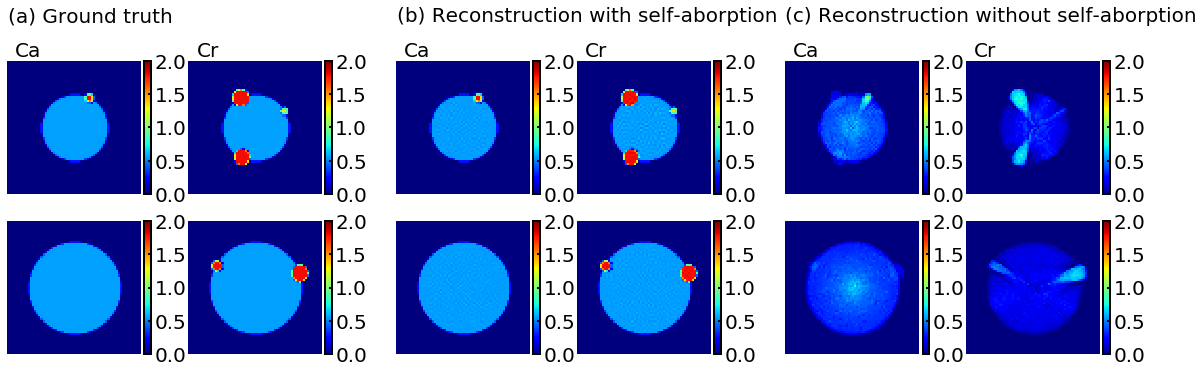

In [48]:
# layer_idx_ls = range(0,5,1)
layer_idx_ls = [10, 40]

gt = np.load(os.path.join(grid_path, f_grid))
recon_selfAb = np.load(os.path.join(recon_path_selfAb, f_recon_grid + '.npy'))
recon_woSelfAb = np.load(os.path.join(recon_path_woSelfAb, f_recon_grid + '.npy'))

image_size = gt.shape[-1]
fig6 = plt.figure(figsize=(2.5 * (3*gt.shape[0]+2) , 3*len(layer_idx_ls)*0.9))
gs6 = gridspec.GridSpec(nrows = len(layer_idx_ls), ncols=3 * gt.shape[0]+2, width_ratios=[2]*gt.shape[0]+[0.05]+[2]* gt.shape[0]+[0.05]+[2]* gt.shape[0])

fig6.text(0.13, 0.98, '(a) Ground truth', color='black', fontsize=20)
fig6.text(0.4, 0.98, '(b) Reconstruction with self-aborption', color='black', fontsize=20)
fig6.text(0.67, 0.98, '(c) Reconstruction without self-aborption', color='black', fontsize=20)

fig6.text(0.135, 0.89, 'Ca', color='black', fontsize=20)
fig6.text(0.261, 0.89, 'Cr', color='black', fontsize=20)
fig6.text(0.405, 0.89, 'Ca', color='black', fontsize=20)
fig6.text(0.531, 0.89, 'Cr', color='black', fontsize=20)
fig6.text(0.675, 0.89, 'Ca', color='black', fontsize=20)
fig6.text(0.801, 0.89, 'Cr', color='black', fontsize=20)

for element_idx in range(gt.shape[0]):
    for idx, layer_idx in enumerate(layer_idx_ls):
        fig6_ax1 = fig6.add_subplot(gs6[idx, element_idx])
        fig6_ax1.set_xticks(np.arange(0, image_size, 1))
        fig6_ax1.set_yticks(np.arange(0, image_size, 1))
        # fig6_ax1.grid(color='w', linewidth=2)
        fig6_ax1.axis('off')
        pos = fig6_ax1.imshow(gt[element_idx,layer_idx], cmap='jet', vmin=0, vmax=2.0, extent=[0, image_size, image_size, 0], origin='upper')
        divider = make_axes_locatable(fig6_ax1)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        ticks = np.array([0, 0.5, 1.0, 1.5, 2.0])
        cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
        cbar.ax.tick_params(labelsize=20, direction='in', width=2)
        cbar.outline.set_linewidth(2)
#         cbar.ax.set_title('intensity', size='14')
        
        fig6_ax1 = fig6.add_subplot(gs6[idx, element_idx+3])
        fig6_ax1.set_xticks(np.arange(0, image_size, 1))
        fig6_ax1.set_yticks(np.arange(0, image_size, 1))
        # fig6_ax1.grid(color='w', linewidth=2)
        fig6_ax1.axis('off')
        pos = fig6_ax1.imshow(recon_selfAb[element_idx,layer_idx], cmap='jet', vmin=0, vmax=2.0, extent=[0, image_size, image_size, 0], origin='upper')
        divider = make_axes_locatable(fig6_ax1)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        ticks = np.array([0, 0.5, 1.0, 1.5, 2.0])
        cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
        cbar.ax.tick_params(labelsize=20, direction='in', width=2)
        cbar.outline.set_linewidth(2)
#         cbar.ax.set_title('intensity', size='14')

        fig6_ax1 = fig6.add_subplot(gs6[idx, element_idx+6])
        fig6_ax1.set_xticks(np.arange(0, image_size, 1))
        fig6_ax1.set_yticks(np.arange(0, image_size, 1))
        # fig6_ax1.grid(color='w', linewidth=2)
        fig6_ax1.axis('off')
        pos = fig6_ax1.imshow(recon_woSelfAb[element_idx,layer_idx], cmap='jet', vmin=0, vmax=2.0, extent=[0, image_size, image_size, 0], origin='upper')
        divider = make_axes_locatable(fig6_ax1)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        ticks = np.array([0, 0.5, 1.0, 1.5, 2.0])
        cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
        cbar.ax.tick_params(labelsize=20, direction='in', width=2)
        cbar.outline.set_linewidth(2)
#         cbar.ax.set_title('intensity', size='14')

plt.savefig('Self_absorption_effect.pdf', format='pdf', dpi=600)

## Plot error convergence

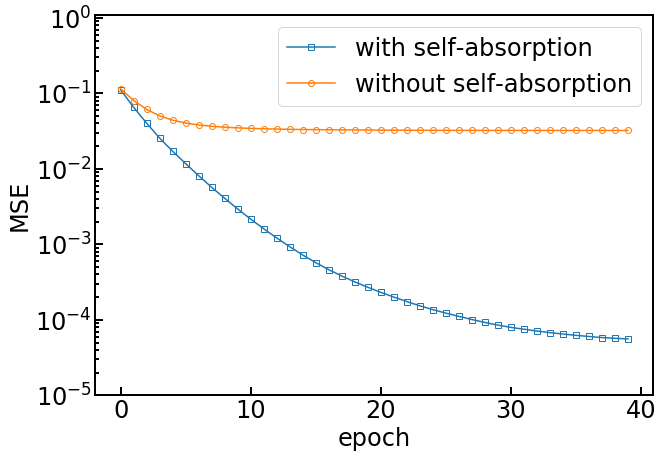

In [41]:
mse_model_selfAb = np.load(os.path.join(recon_path_selfAb, f_mse_model + '.npy'))
mse_model_woSelfAb = np.load(os.path.join(recon_path_woSelfAb, f_mse_model + '.npy'))
epoch_ls = np.arange(0,40)

fig0 = plt.figure(figsize = (10,7))
gs0 = gridspec.GridSpec(nrows=1, ncols=1)

fig0_ax0 = fig0.add_subplot(gs0[0,0])
fig0_ax0.plot(epoch_ls, mse_model_selfAb, marker='s', fillstyle='none', label="with self-absorption")
fig0_ax0.plot(epoch_ls, mse_model_woSelfAb, marker='o', fillstyle='none', label="without self-absorption")
fig0_ax0.set_yscale('log')
fig0_ax0.set_xlabel("epoch", fontsize=24)
fig0_ax0.set_ylabel("MSE", fontsize=24)
fig0_ax0.set_ylim([1.0E-5, 1.1])
fig0_ax0.tick_params(axis='both', which='major', labelsize=24, width=2, length=8)
fig0_ax0.tick_params(axis='both', which='major', direction='in', width=2, length=8)
fig0_ax0.tick_params(axis='both', which='minor', labelsize=24, width=2, length=4)
fig0_ax0.tick_params(axis='both', which='minor', direction='in', width=2, length=4)
fig0_ax0.spines["top"].set_linewidth(2)
fig0_ax0.spines["bottom"].set_linewidth(2)
fig0_ax0.spines["left"].set_linewidth(2)
fig0_ax0.spines["right"].set_linewidth(2)
fig0_ax0.legend(fontsize=24)
plt.savefig('Self_absorption_effect_convergence.pdf', format='pdf', dpi=600)